# Simple demonstration of XMM: Generate and Analyse (XGA)

### Disclaimer - XGA has only reached first alpha release, it can be super buggy and only has minimal functionality at the moment - please visit the GitHub (https://github.com/DavidT3/XGA) to submit issues (also feel free to email me at david.turner@sussex.ac.uk, but submit an issue as well)

In [1]:
from astropy.units import Quantity, pix, deg
from astropy.cosmology import Planck15
import numpy as np

# On first import, XGA checks the information in its config file, and updates its observation census, so it knows 
#  what observations are available and approximately where they are pointing.
from xga.sources import ExtendedSource, BaseSource, GalaxyCluster
from xga.sas import evselect_image, emosaic, eexpmap, evselect_spectrum
from xga.utils import xmm_sky, xmm_det
from xga.xspec import single_temp_apec

## Defining some sources

XGA revolves around 'source' objects, which are analogous to X-ray sources in real life. At their most basic they have a position and a redshift (though redshift is optional for some objects). They find all available XMM observations that the source appears in, and load available images and exposure maps into XGA product objects. They also load available region files.

Currently implemented source classes are:
* **BaseSource** - The superclass for all the other source classes, there are very few circumstances where this class should be initialised by users.


* **ExtendedSource** - Using this source adds context for XGA, it matches the position to extended sources in region files. It also finds the X-ray centroid independently of region file regions, in case the source was not detected. ExtendedSources can be used with spectrum generation and fitting functionality. Can also pass a custom region radius to allow a custom region to be used for spectrum generation and fitting.


* **GalaxyCluster** - What it says on the tin, this is specifically for clusters, and is a subclass of ExtendedSource. These require a redshift to be passed, as well as **at least** one overdensity radius. Also supports passing weak lensing mass and richness, for use later, and further multi-wavelength observables will be added. This class hasn't been very fleshed out as of 01/07/20, but I'm working on it.


* **PointSource** - Similar to the ExtendedSource class, but with nothing in it as of 01/07/20, very little functionality.

In [2]:
# These are all Galaxy Clusters, but I'm using the ExtendedSource class because it requires fewer inputs 
#  for a simple demonstration

# Radius quantity used for demonstration of custom region - can be defined in degrees 
#  if a redshift is supplied to the source object.
cust_rad = Quantity(1000, 'kpc')

# My favourite test cluster, you can give the object a name, otherwise it'll generate one based on position
# You can also choose the cosmology you want to use for the analysis, it gets passed through to XSPEC too
a907 = ExtendedSource(149.5904478, -11.0628750, redshift=0.16, name="A907", cosmology=Planck15, load_products=True,
                      load_fits=True, custom_region_radius=cust_rad)

# This cluster I just pulled from the XCS-SDSS paper
# The default cosmology is actually Planck15, so I don't bother to set it here
rand_clust_0 = ExtendedSource(250.0833, 46.7075, 0.233, "XMMXCSJ164020.2+464227.1", load_products=True, 
                              load_fits=True)

# I don't bother setting a name for this one, to generate the auto generation of names
rand_clust_1 = ExtendedSource(216.5042, 37.8269, redshift=0.175, load_products=True, load_fits=True)

# Final random cluster, XMMXCSJ224154.6+173216.8
rand_clust_2 = ExtendedSource(340.4775000, 17.5380000, redshift=0.313, name="XMMXCSJ224154.6+173216.8", 
                              load_products=True, load_fits=True)

/home/dt237/code/PycharmProjects/XGA/xga/products.py:303: UserWarning: You are loading an ratemap with elements that are < 0, they will be set to 0.
  warnings.warn("You are loading an {} with elements that are < 0, "
/home/dt237/code/PycharmProjects/XGA/xga/products.py:303: UserWarning: You are loading an image with elements that are < 0, they will be set to 0.
  warnings.warn("You are loading an {} with elements that are < 0, "
Generating products of type(s) expmap: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


The load_products and load_fits flags on initialisation just tell XGA that it should check its output directory for products that it has already generated (in past runs for instance) and fits it has already performed, and load them into the source objects if available.

## Using the info method to get some basic information about the sources

In [3]:
a907.info()
rand_clust_0.info()
rand_clust_1.info()
rand_clust_2.info()


-----------------------------------------------------
Source Name - A907
User Coordinates - (149.5904478, -11.062875) degrees
X-ray Centroid - (149.59251340970866, -11.063958320861634) degrees
nH - 0.0534 1e+22 / cm2
XMM Observations - 3
On-Axis - 3
With regions - 3
Total regions - 69
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 18
Spectra associated - 0
Custom Region Radius - 1000.0 kpc
Custom Region SNR - 3.58
-----------------------------------------------------


-----------------------------------------------------
Source Name - XMMXCSJ164020.2+464227.1
User Coordinates - (250.0833, 46.7075) degrees
X-ray Centroid - (250.08319045416954, 46.712661682955044) degrees
nH - 0.0168 1e+22 / cm2
XMM Observations - 3
On-Axis - 3
With regions - 3
Total regions - 65
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 18
Spectra associated - 0
-----------------------------------------------------

## Masks and Regions

When an extended source is initialised, it goes through a process of matching to regions, deciding which is the source (if any), and deciding which are nuisance sources that need to be removed. It uses the astropy adjacent module 'regions', which is still in early development but has some very cool features. It generates image masks in the form of numpy True False arrays that make it really easy to look at only the source. 

The mask generation steps are also performed for any custom or overdensity regions that are declared.

As well as source region masks, XGA also creates background region masks. There are get methods that make it easy to retrieve source+background regions, interloper sources, source masks, and to convert them into a SAS compatible form (though that last one isn't really meant for use by anything but the SAS functions).

In [4]:
# For instance, here I grab the mask that I'll use later to demonstrate the view method of image products
# This mask is generated from the region file, but if I used "custom" rather than "region" I could get a mask
#  for the custom region we defined earlier.

# This method returns both the source and background masks
example_source_mask, example_back_mask = a907.get_mask("region", "0201903501", "pn")

# Actually I will grab the custom region as well - this was made on the merged products, so won't be applicable to
#  non-merged images
example_custom_mask, example_custom_back_mask = a907.get_mask("custom", "0201903501", "pn")

## Basic SAS commands - Generating images and exposure maps

Generating SAS products is key to the analysis of objects in XMM data.

Naturally you want to use all the data that is available for a given object, so XGA automatically finds the observations that a particular source is present in.

Then, whenever a SAS command is called for a particular source, the products are automatically generated for every instrument of every observation available for that source.

In [5]:
# Define the energy range you want the images in, if such an image already exists it will be detected
#  and won't be generated again

# The limits need to be astropy quantities, so they can be any energy unit, they'll be auto converted to eV and then
#  to XMM channels
l = Quantity(0.5, 'keV')
u = Quantity(4.0, 'keV')

# XGA is designed to deal with populations of objects, every generation can take N sources
# The way it executes SAS tasks will change dependant on the system you're running on. If you're on a local machine,
#  the SAS tasks will run in parallel, using 90% of your cores by default, if you're on an HPC it will 
#  submit jobs (but that isn't implemented yet).

# So, we generate the images in this new energy band for all our sources
all_sources = [a907, rand_clust_0, rand_clust_1, rand_clust_2]
# Once the images are generated, they are read into XGA 'Product' classes, and assigned to a source, which is 
#  why this returns the source objects afterwards.
all_sources = evselect_image(all_sources, l, u)

# But images are of limited use without exposure maps, so now we need them to!
# eexpmap first checks that there are appropriate cif files available, as they are required for 
#  exposure map generation, if there aren't, then it makes them
all_sources = eexpmap(all_sources, l, u)

# Generating exposure maps actually requires images as a base, so what if you decided you wanted exposure maps in 
#  a new energy band but you forgot to make the images first?
l = Quantity(4.0, 'keV')
u = Quantity(8.0, 'keV')
all_sources = eexpmap(all_sources, l, u)  
# All is fine! XGA checks that the required images exist, finds that they don't, and then generates them first.

Generating products of type(s) expmap: 100%|██████████| 27/27 [01:32<00:00,  3.44s/it]


## Interacting with Product Objects

For basic analyses built in to XGA, users shouldn't need to interact directly with the product objects, but when it comes to more complex work, it is easy for the user to retrieve the products they need

In [6]:
# Just going to use Abell 907 as an example, not the other three

# Every source object has a get_products method, which can be used to grab specific product types
a907_images = a907.get_products("image")
print("All A907 Image Objects:\n", a907_images, "\n")

# It can be used more specifically, just retrieving products from a specific observation and instrument
a907_specific_images = a907.get_products("image", obs_id="0201903501", inst="pn")
print("More specific A907 images:\n", a907_specific_images, "\n")

# There is a boolean flag that will return more information about the image with the actual object
a907_specific_images = a907.get_products("image", obs_id="0201903501", inst="pn", just_obj=False)
print("More specific A907 images with more information:\n", a907_specific_images, "\n")

# The extra information returned with that flag can also be accessed from an image object itself
example_image = a907.get_products("image", obs_id="0201903501", inst="pn")[0]
print(example_image.obs_id, example_image.instrument, example_image.energy_bounds, '\n')

# Each type of product has different abilities, don't have time to show them all off right now
# But one useful function of image objects is a coordinate conversion method that will go from any relevant 
#  XMM coordinates to pixels/radec and back again. I've also created custom astropy units for detector and sky XMM
#  coords.
# There will be a view() method to get a quick look at the image, but I haven't written that yet.

# When the SAS interface generates a product, it will parse the terminal output for errors and warnings.
#  Currently the default behaviour is to throw a Python error if there is a proper SAS error, but errors 
#  and warnings are stored within the product as well, for instance:
print("SAS Errors", example_image.sas_errors)
print("SAS Warnings", example_image.sas_warnings, '\n')

# And quickly, XGA ExpMap objects are pretty bare bones currently, but it can return the exposure at 
#  a specific coordinate! This example prints the exposure at the user supplied ra and dec.
example_expmap = a907.get_products("expmap", obs_id="0201903501", inst="pn")[0]
print("Exposure time at A907 initilisation coordinates:", example_expmap.get_exp(a907.ra_dec))

All A907 Image Objects:
 [<xga.products.Image object at 0x7f0989c97280>, <xga.products.Image object at 0x7f0989c97340>, <xga.products.Image object at 0x7f098e16bd00>, <xga.products.Image object at 0x7f098e1031c0>, <xga.products.Image object at 0x7f0989c97670>, <xga.products.Image object at 0x7f0989c97700>, <xga.products.Image object at 0x7f098e0f2220>, <xga.products.Image object at 0x7f0988e59d90>, <xga.products.Image object at 0x7f0989c97a00>, <xga.products.Image object at 0x7f0989c978b0>, <xga.products.Image object at 0x7f098e0f2340>, <xga.products.Image object at 0x7f0988e59eb0>, <xga.products.Image object at 0x7f0989c97af0>, <xga.products.Image object at 0x7f0989c97ee0>, <xga.products.Image object at 0x7f098e0f23d0>, <xga.products.Image object at 0x7f098e100e50>, <xga.products.Image object at 0x7f0989c97c40>, <xga.products.Image object at 0x7f0989c271c0>, <xga.products.Image object at 0x7f098e0f2460>, <xga.products.Image object at 0x7f0988e5b130>, <xga.products.Image object at 0x7f

If you have extracted an image or exposure map product object, you can use the view method to take a quick look at them. You can't customise the colormap or scaling or anything like that, but in the future there will be another way of looking at sources that does allow that.

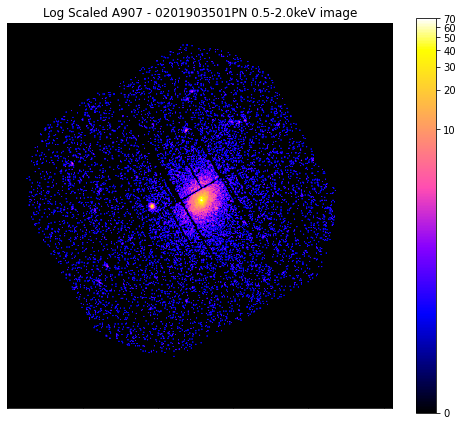

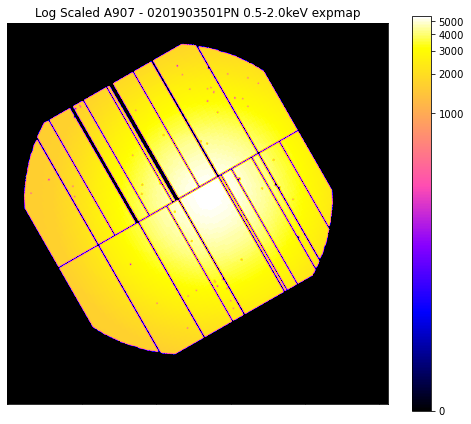

In [7]:
# Having a look at the example image and exposure map
example_image.view()

example_expmap.view()

I can also pass a coordinate, which is then plotted as a crosshair on the image.

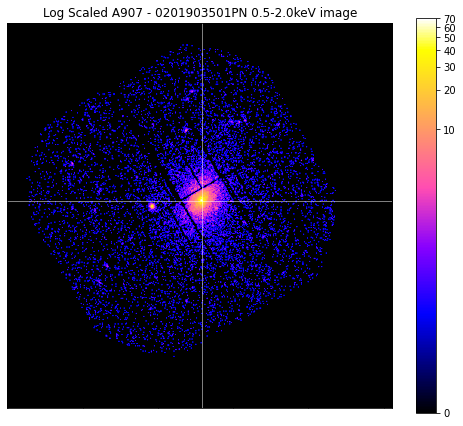

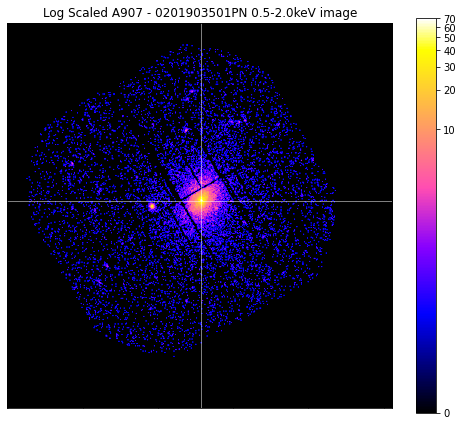

In [8]:
# So first I plot the cross hair at the user supplied coordinates
example_image.view(cross_hair=a907.ra_dec)

# And then I plot the X-ray centroid measured from the combined ratemap
example_image.view(cross_hair=a907.peak)

And finally, we can pass a mask and only look at a particular region of interest. The mask itself is just a numpy array of the same size as the image, with True and False values - so a user could easily make their own if they wanted.

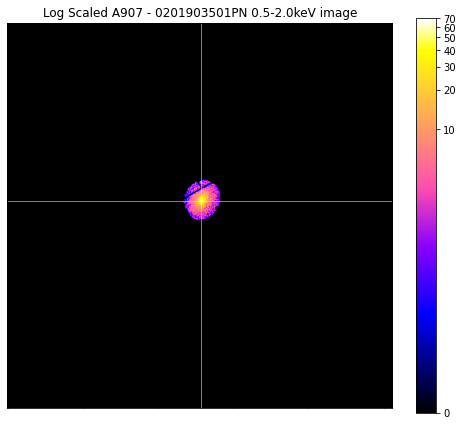

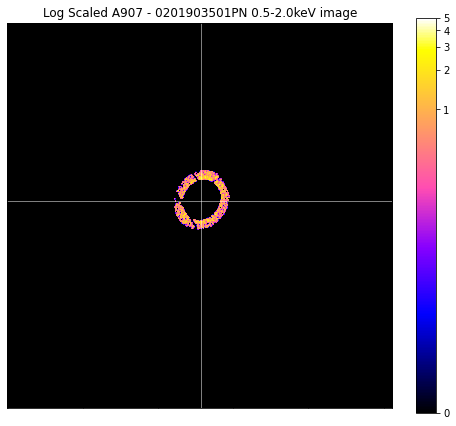

In [9]:
# First look at the source region
example_image.view(cross_hair=a907.peak, mask=example_source_mask)

# Then have a look at the corresponding background region that was auto generated 
example_image.view(cross_hair=a907.peak, mask=example_back_mask)

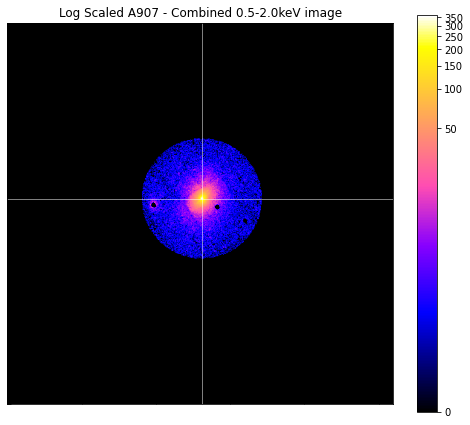

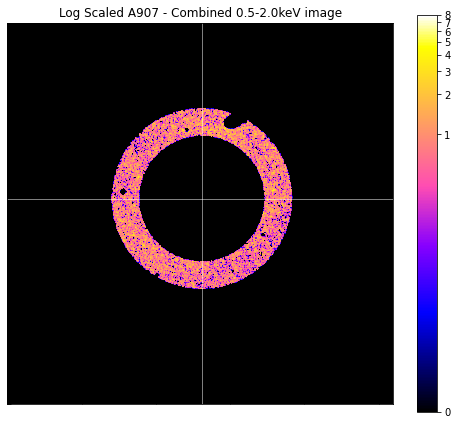

In [10]:
# We can also look at the custom region mask, BUT ONLY ON THE MERGED IMAGE, as that 
#  was what the custom mask was made for.
merged_image = a907.get_products("combined_image")[0]

merged_image.view(cross_hair=a907.peak, mask=example_custom_mask)
merged_image.view(cross_hair=a907.peak, mask=example_custom_back_mask)

## Key product object - RateMaps

A key type of product I've introduced is the RateMap. Not something that SAS produces itself, but something everyone has to make if they want to perform analyses on X-ray photometry. Essentially just the division of an image by a matching exposure map.

XGA creates these automatically when it notices that a matching pair of image and exposure map (matching in energy range, ObsID, instrument) exist, but a matching ratemap doesn't. It also does this for merged images and exposure maps - the merged ratemaps are the most important, as that is what all XGA analysis will be performed on.

The RateMaps behave in a similar way to image and exposure map product objects, but have several methods for peak finding and edge detection that set them apart.

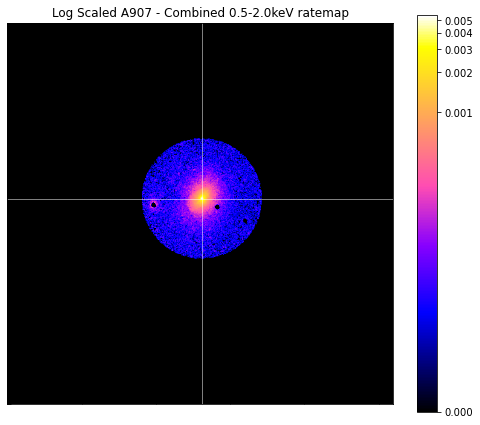

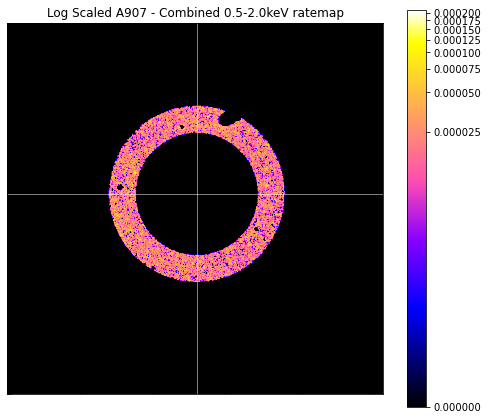

In [11]:
# We'll just look at the combined ratemap for a quick demonstration
merged_ratemap = a907.get_products("combined_ratemap")[0]

# It doesn't look that different for on axis objects (like this one), but off axis the 
#  image and ratemap could look quite different
merged_ratemap.view(cross_hair=a907.peak, mask=example_custom_mask)
merged_ratemap.view(cross_hair=a907.peak, mask=example_custom_back_mask)

## More interesting SAS commands - generating spectra

The evselect_spectrum command generates minimally grouped spectra by default, with a minimum of 5 counts per channel. This aims to remove 0 count channels while still keeping counting statistics valid. You can also pass a minimum signal to noise value, and the amount you want the energy resolution to be oversampled. Again, you can tell it how many cores you want it to use.

In [12]:
# Giving evselect_spectrum reg_type="region" tells it to try and use the regions from region files to 
#  generate spectra. Each observation may have some variation in the size and positioning of the region file,
#  and some sources may not have had a long enough exposure for the source finder to detect the object at all.
all_sources = evselect_spectrum(all_sources, reg_type="region")

Generating products of type(s) spectrum: 100%|██████████| 27/27 [08:37<00:00, 19.16s/it]  


We only gave one of these sources a custom region radius (A907), so we'll generate spectra for that custom radius only for that source. By default the custom source is centred on the X-ray centroid (which is automatically found by ExtendedSource and GalaxyCluster objects), but can be centred on the initialisation coordinates instead, if that option is passed at source initialisation.

In [13]:
# Generates A907 spectra for the custom region
a907 = evselect_spectrum(a907, reg_type="custom")

Generating products of type(s) spectrum: 100%|██████████| 9/9 [08:10<00:00, 54.47s/it] 


## The XSPEC interface

The XSPEC interface was originally going to use the pyXSPEC module, but it was far too restrictive, and would have made it much harder to fit different sources in parallel. What XGA does instead is generate XSPEC scripts by filling in an XSPEC script template that is run on the command line (in the same way SAS commands are) and eventually saves its results to csv files. This allows me to easily run it in parallel on a local machine, though again HPC support hasn't been implemented yet (as of 01/07/20).

The single temperature apec fit is the only one implemented currently, but I will also provide a two temperature apec fit, and a completely general (fingers crossed) function that lets people define their own XSPEC models. I've scraped the XSPEC model list to know what parameters are required, and the XSPEC template script I wrote is very dynamic and generalised so hopefully it'll be fine.

In [14]:
# These are all clusters I've defined, so a single temperature apec is appropriate. 
# There are many many options that can be passed to this fit, but I won't go into them here
all_sources = single_temp_apec(all_sources, "region")

# This will fit the same model to the custom region for A907
a907 = single_temp_apec(a907, "custom")

Running XSPEC Models Fits: 100%|██████████| 1/1 [00:41<00:00, 41.69s/it]


## Accessing fit results

Once a fit has been run, information specific to different spectra (like plotting data, individual luminosities, individual count rates) are added to those spectrum product objects. They can all be retrieved by interacting with the spectrum objects themselves

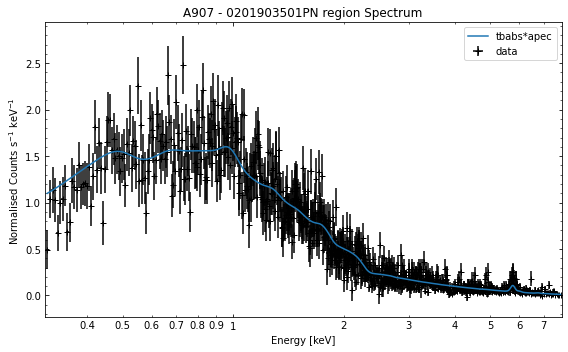

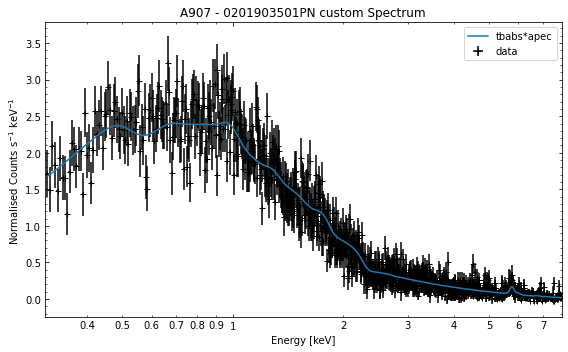

In [15]:
# Once a fit has been performed, extra information and plotting data is added to the relevant 
#  spectrum product objects
# This grabs a specific region file region spectrum, and demonstrates the view() method
example_region_spec = a907.get_products("spectrum", obs_id="0201903501", inst="pn", extra_key="region")[0]
example_region_spec.view()

# Here I get the equivalent A907 spectrum, but for the custom region we defined earlier.
example_custom_spec = a907.get_products("spectrum", obs_id="0201903501", inst="pn", extra_key="custom")[0]
example_custom_spec.view()

In [16]:
# As each spectrum has its own luminosity calculated separately, luminosities can be retrieved from every spectrum
# This will return all lums associated with the single temperature apec model, and you can ask for a 
#  luminosity calculated within certain energy limits specifically if you want.

# This returns a dictionary with the different energy band luminosities that were measured (they can be changed
#  in the original fit call) - provides the result, then - and + errors
region_lums = example_region_spec.get_luminosities("tbabs*apec")
print('Region Luminosities:\n', region_lums, "\n")

custom_lums = example_custom_spec.get_luminosities("tbabs*apec")
print('Custom Region Luminosities:\n', custom_lums)

Region Luminosities:
 {'bound_0.5-2.0': [<Quantity 2.32448717e+44 erg / s>, <Quantity 1.6139665e+42 erg / s>, <Quantity 1.5506154e+42 erg / s>], 'bound_0.01-100.0': [<Quantity 7.69952738e+44 erg / s>, <Quantity 6.3318182e+42 erg / s>, <Quantity 8.8889613e+42 erg / s>]} 

Custom Region Luminosities:
 {'bound_0.5-2.0': [<Quantity 4.22481557e+44 erg / s>, <Quantity 1.9596273e+42 erg / s>, <Quantity 2.5812989e+42 erg / s>], 'bound_0.01-100.0': [<Quantity 1.45357588e+45 erg / s>, <Quantity 9.538549e+42 erg / s>, <Quantity 1.1660082e+43 erg / s>]}


The overall results and luminosities get stored in the source object, and can be easily retrieved.

In [17]:
# Retrieving the temperature from the region spectra fit - the GalaxyCluster 
#  class has a method just to get temperature, though this general one can still be used.
region_temp = a907.get_results("region", "tbabs*apec", "kT")
# This returns a numpy array with the temperature value, and its minus and plus errors

print("Temperature in region spectra is", "{0} -{1} +{2}".format(*region_temp))

# Do the same for the custom region
custom_temp = a907.get_results("custom", "tbabs*apec", "kT")

print("Temperature in custom spectra is", "{0} -{1} +{2}".format(*custom_temp))

Temperature in region spectra is 5.14535 -0.06743888899999995 +0.06785901500000069
Temperature in custom spectra is 5.56201 -0.09090711599999944 +0.09106509400000018
